# TensorBoard の DataFrames データにアクセスする

https://www.tensorflow.org/tensorboard/dataframe_api?hl=ja

## 概要

TensorBoard の主な機能はインタラクティブ GUI ですが、ログれーたの事後分析やカスタム視覚化の作成目的で、TensorBoard に保存されているデータログを プログラムで 読み取るユーザーもいます。

TensorBoard 2.3 は、tensorboard.data.experimental.ExperimentFromDev() でこのようなユースケースをサポートしており、TensorBoard のスカラーログにプログラムを使ってアクセスすることができます。このページでは、この新しい API の基本的な使用方法を実演します。

注意: 1. この API は、名前空間で想像できるように、まだ実験段階にある API です。そのため、将来的に重大な変更が適用される場合があります。 2. 現在のところ、この機能は TensorBoard.dev にアップロードされる logdir のみをサポートしています。TensorBoard.dev は、TensorBoard の永続化と共有を可能にする無料のホステッドサービスです。ローカルに保存されている TensorBoard logdir のサポートは、今後追加される予定です。簡単に言うと、ローカルのファイルシステムに保存されている TensorBoard logdir を、1 行のコマンド（tensorboard dev upload --logdir <logdir>）で TensorBoard.dev にアップロードすることができます。詳細は、tensorboard.dev をご覧ください。
    
## セットアップ

プログラマティック API を使用するには、tensorboard とともに pandas がインストールされていることを確認してください。

このガイドではカスタムプロットの作成に matplotlib と seaborn を使用しますが、任意のツールを使って DataFrame の分析と視覚化を行えます。

In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [2]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.7.0


## pandas.DataFrame として TensorBoard スカラーを読み込む

TensorBoard logdir が TensorBoard.dev にアップロードされると、logdir は「実験」となります。各実験には一意の ID が割り当てられており、実験の TensorBoard.dev URL で確認することができます。次のデモでは、https://tensorboard.dev/experiment/c1KCv3X3QvGwaXfgX1c4tg にある TensorBoard.dev を使用しています。




In [3]:
experiment_id = "c1KCv3X3QvGwaXfgX1c4tg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,"adam,run_1/train",epoch_accuracy,0,0.966867
1,"adam,run_1/train",epoch_accuracy,1,0.986283
2,"adam,run_1/train",epoch_accuracy,2,0.989333
3,"adam,run_1/train",epoch_accuracy,3,0.991933
4,"adam,run_1/train",epoch_accuracy,4,0.991733
...,...,...,...,...
1195,"sgd,run_5/validation",epoch_loss,15,0.020157
1196,"sgd,run_5/validation",epoch_loss,16,0.020212
1197,"sgd,run_5/validation",epoch_loss,17,0.020364
1198,"sgd,run_5/validation",epoch_loss,18,0.022192


df は、実験のすべてのスカラーログを含む pandas.DataFrame です。

DataFrame の列は次のとおりです。

* run: run（実行）は、元の logdir のサブディレクトリに対応しています。この実験では、run は特定のオプティマイザタイプ（トレーニングハイパーパラメータ）を使用した MNIST データセットのニューラルネットワーク（CNN）の完全なトレーニングに由来しています。この DataFrame は、このような run が複数含まれており、別のオプティマイザタイプの配下にある反復トレーニングに対応しています。
* tag: これは、同一の行にある value の意味、つまり値が表現するメトリックが何であるかを記述しています。この実験では、epoch_accuracy と epoch_loss という、それぞれ精度と損失のメトリックに対応する 2 つのタグのみがあります。
* step: これは、run の中で対応する行のシリアル順を反映する番号です。ここでは、step は実際にエポック番号を指します。step 値とは別にタイムスタンプを取得する場合は、get_scalars() を呼び出す際にキーワード引数 include_wall_time=True を使用できます。
* value: これは関心のある実際の数値です。上述のとおり、この特定の DataFrame の各 value は、行の tag に応じて損失か精度になります。




In [4]:
print(df["run"].unique())
print(df["tag"].unique())

['adam,run_1/train' 'adam,run_1/validation' 'adam,run_2/train'
 'adam,run_2/validation' 'adam,run_3/train' 'adam,run_3/validation'
 'adam,run_4/train' 'adam,run_4/validation' 'adam,run_5/train'
 'adam,run_5/validation' 'rmsprop,run_1/train' 'rmsprop,run_1/validation'
 'rmsprop,run_2/train' 'rmsprop,run_2/validation' 'rmsprop,run_3/train'
 'rmsprop,run_3/validation' 'rmsprop,run_4/train'
 'rmsprop,run_4/validation' 'rmsprop,run_5/train'
 'rmsprop,run_5/validation' 'sgd,run_1/train' 'sgd,run_1/validation'
 'sgd,run_2/train' 'sgd,run_2/validation' 'sgd,run_3/train'
 'sgd,run_3/validation' 'sgd,run_4/train' 'sgd,run_4/validation'
 'sgd,run_5/train' 'sgd,run_5/validation']
['epoch_accuracy' 'epoch_loss']


## ピボット（ワイドフォーム）DataFrame を取得する

この実験では、各実行の同じステップ時Iに 2 つのタグ（epoch_loss と epoch_accuracy）が存在します。このため、pivot=True キーワード引数を使用することで、「ワイドフォーム」DataFrame を get_scalars() から直接取得することができます。すべてのタグがワイドフォーム DataFrame の列として含まれているため、このケースを含み、場合によっては操作がより便利になります。

ただし、すべての実行のすべてのタグで統一したステップ値を持つ条件が満たされる場合、pivot=True を使用するとエラーになることに注意してください。

In [5]:
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,epoch_accuracy,epoch_loss
0,"adam,run_1/train",0,0.966867,0.110196
1,"adam,run_1/train",1,0.986283,0.042437
2,"adam,run_1/train",2,0.989333,0.032622
3,"adam,run_1/train",3,0.991933,0.026121
4,"adam,run_1/train",4,0.991733,0.024742
...,...,...,...,...
595,"sgd,run_5/validation",15,0.993800,0.020157
596,"sgd,run_5/validation",16,0.993500,0.020212
597,"sgd,run_5/validation",17,0.993800,0.020364
598,"sgd,run_5/validation",18,0.993100,0.022192


ワイドフォーム DataFrame には、1 つの「value」列の代わりに、epoch_accuracy と epoch_loss の 2 つのタグ（メトリック）が列として明示的に含まれています。

## DataFrame を CSV として保存する

pandas.DataFrame には、CSV との十分な互換性があるため、ローカル CSV ファイルとして保存し、後で読み込み直すことができます。次に例を示します。

In [7]:
csv_path = './tmp/tb_experiment_1.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

## カスタム視覚化と統計分析を実行する

Text(0.5, 1.0, 'loss')

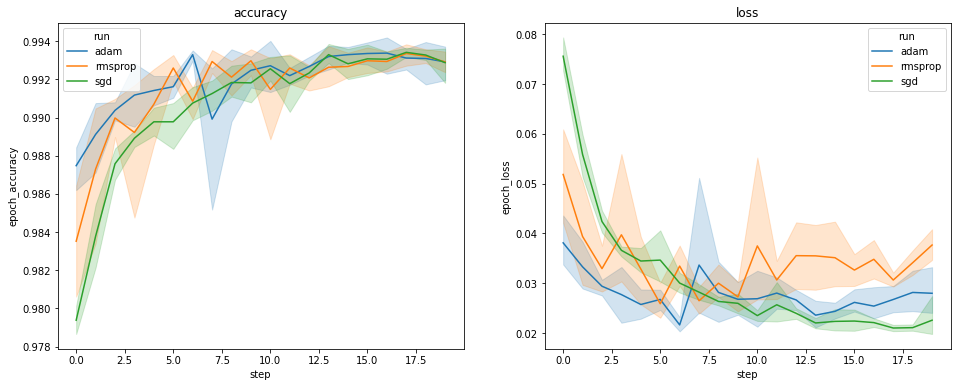

In [8]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 2, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

上記のプロットは、検証精度と検証損失のタイムコースを示し、それぞれの曲線は、あるオプティマイザタイプによる 5 回の実行の平均を示します。seaborn.lineplot() に組み込まれた機能により、それぞれの曲線は、平均に関する ±1 の標準偏差も表示するため、曲線の変動性と 3 つのオプティマイザの差の重要性がわかりやすくなります。この変動性の視覚化は、TensorBoard の GUI ではまだサポートされていません。

最小検証損失が「adam」、「rmsprop」、および「sgd」オプティマイザ間で大きく異なるという仮説を調べるため、それぞれのオプティマイザにおける最小検証損失の DataFrame を抽出します。

そして、最小検証損失の差を視覚化する箱ひげ図を作成します。

<AxesSubplot:xlabel='run', ylabel='epoch_loss'>

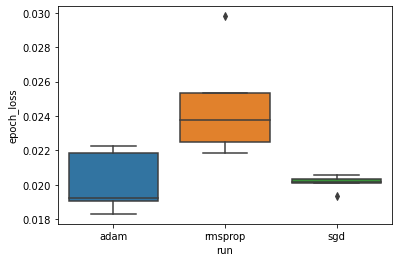

In [9]:
adam_min_val_loss = dfw_validation.loc[optimizer_validation=="adam", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
rmsprop_min_val_loss = dfw_validation.loc[optimizer_validation=="rmsprop", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
sgd_min_val_loss = dfw_validation.loc[optimizer_validation=="sgd", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
min_val_loss = pd.concat([adam_min_val_loss, rmsprop_min_val_loss, sgd_min_val_loss])

sns.boxplot(data=min_val_loss, y="epoch_loss",
            x=min_val_loss.run.apply(lambda run: run.split(",")[0]))

In [10]:
# Perform pairwise comparisons between the minimum validation losses
# from the three optimizers.
_, p_adam_vs_rmsprop = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    rmsprop_min_val_loss["epoch_loss"]) 
_, p_adam_vs_sgd = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
_, p_rmsprop_vs_sgd = stats.ttest_ind(
    rmsprop_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
print("adam vs. rmsprop: p = %.4f" % p_adam_vs_rmsprop)
print("adam vs. sgd: p = %.4f" % p_adam_vs_sgd)
print("rmsprop vs. sgd: p = %.4f" % p_rmsprop_vs_sgd)

adam vs. rmsprop: p = 0.0244
adam vs. sgd: p = 0.9749
rmsprop vs. sgd: p = 0.0135


したがって、分析では、重要度レベル 0.05 で、最小検証損失が、実験に含まれるほかの 2 つのオプティマイザよりも rmsprop オプティマイザの方が大幅に高い（つまり悪化する）という仮説が実証されます。

まとめると、このチュートリアルでは、 TensorBoard.dev から panda.DataFrame のスカラーデータにアクセスする例を示しました。DataFrame を使用して行える柔軟で強力な分析と視覚化を実演しました。